In [2]:
import torch
import argparse
import csv   
import datetime

import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
from validationUtils import *
from plotUtils import *
from TUutils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [7]:
df = pd.read_csv('Logs/wgangp-2019-11-28_114731.csv', header=None)
#data = pd.read_pickle('Data/TU_onehot')
#data = back_from_dummies(data)
#data = data.drop(['HomeAdrMunCode'], axis=1)
#data = encode_onehot(data)

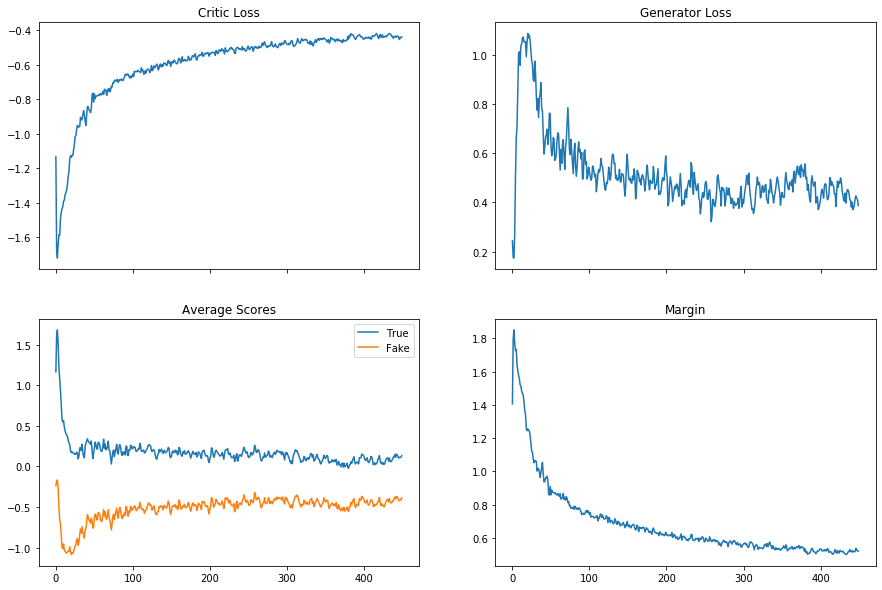

In [31]:
# Creates four polar axes, and accesses them through the returned array
df = pd.read_csv('Logs/wgangp-2019-11-28_114731.csv', header=None)

fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex='all')

axes[0, 0].plot(df[1])
axes[0, 0].set_title('Critic Loss')
axes[0, 1].plot(df[2])
axes[0, 1].set_title('Generator Loss')
axes[1, 0].plot(df[3])
axes[1, 0].plot(df[4])
axes[1, 0].legend(['True', 'Fake'])
axes[1, 0].set_title('Average Scores')
axes[1, 1].plot(df[3] - df[4])
axes[1, 1].set_title('Margin')


plt.show()

In [43]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

INPUT_SIZE = 36
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [45]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 temperature: float,
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        self.temperature = torch.Tensor([temperature]).to(device)
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size * 2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([sample_gumbel_softmax(v, temperature = self.temperature) for v in x], dim=1)
        return out

G = torch.load('Logs/wgangp-2019-11-27_125742')

In [48]:
G = G.to(device)
z = gen_noise(INPUT_SIZE, 1000).to(device)

In [76]:
output = G.forward(z)
output = output.cpu().detach().numpy()
output = output.astype(int)

In [77]:
fake_data = pd.DataFrame(output, columns=data.columns)
fake_data.head()

,HomeAdrNUTS_11,HomeAdrNUTS_12,HomeAdrNUTS_13,HomeAdrNUTS_14,HomeAdrNUTS_21,HomeAdrNUTS_22,HomeAdrNUTS_31,HomeAdrNUTS_32,HomeAdrNUTS_41,HomeAdrNUTS_42,...,"HousehNumPersO6_(0.002, 0.00752]","HousehNumDrivLic_(-0.001, 0.000357]","HousehNumDrivLic_(0.000357, 0.000363]","HousehNumDrivLic_(0.000363, 0.000708]","HousehNumDrivLic_(0.000708, 0.000713]","HousehNumDrivLic_(0.000713, 0.000717]","HousehNumDrivLic_(0.000717, 0.000721]","HousehNumDrivLic_(0.000721, 0.000726]","HousehNumDrivLic_(0.000726, 0.001]","HousehNumDrivLic_(0.001, 0.00451]"
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [80]:
fake_data_ = back_from_dummies(fake_data)
true_data = back_from_dummies(data)
true_data.columns

Index(['HomeAdrNUTS', 'RespSex', 'RespPrimOcc', 'RespEdulevel',
       'RespHasBicycle', 'RespHasSeasonticket', 'ResphasDrivlic', 'Handicap',
       'HousehAccomodation', 'PosInFamily', 'NuclFamType',
       'HousehAccOwnorRent', 'HousehCarOwnership', 'RespAgeCorrect',
       'RespDrivlicYear', 'HousehNumcars', 'HousehNumPers', 'HousehNumAdults',
       'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic'],
      dtype='object')

In [99]:
compute_stat(fake_data.values, data.sample(1000).values, True, False)

corr = 0.283333
MAE = 0.095259
RMSE = 5.354718
SRMSE = 76.959842
r2 = -0.471480


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 600x600 with 0 Axes>

In [97]:
data.sample(10).values

TypeError: 'numpy.ndarray' object is not callable